# Imports

In [2]:
import glob
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from scipy.stats import chi2_contingency, kruskal
from support_functions import  get_head_tail, calc_in_relation_to_average
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

font = {'size'   : 45}

matplotlib.rc('font', **font)

# Load main dataset 


In [22]:

input_path = './data/main/*.pkl'
file_names = glob.glob(input_path)

df = []
for f in file_names:
    temp = pd.read_pickle(f)
    df.append(temp)
    
df = pd.concat(df)

# create month column
df['created_at'] = pd.to_datetime(df['created_at'],utc=True)
df['month'] = df['created_at'].dt.strftime('%m')
df['month'] = df['month'].astype(int)

# ignore entries with no tokens (most of them only @handles or urls)
before = len(df)
df = df[df.tokens.str.len() > 0]
df = df.reset_index()
after = len(df)
print(f"Ignoring {before - after} tweets with no content (handles/urls)\n")

# ignore doublications 
df = df.drop_duplicates(subset='id')
print(f"Ignoring {after - len(df)} duplicate tweets \n")

countries =  ['uk', 'wales', 'scotland', 'nireland', 'es', 'gr', 'catalan', 'basque']

Ignoring 23219 tweets with no content (handles/urls)

Ignoring 6722 duplicate tweets 



In [7]:
# Get ratio of retweets/follower and favorite/follower TODO: check possible division with zero
df['retweet_follower_ratio'] = df['retweet_count'] / df['followers_count']
df['favorite_follower_ratio'] = df['favorite_count'] / df['followers_count']

# get avg_retweets for each mp
df['avg_retweets'] = 0
avg_retweets = df.groupby('mp_screen_name')['retweet_count'].mean()

df = df.set_index('mp_screen_name')
df['avg_retweets'] = avg_retweets
df = df.reset_index()

# get "in_relation_to_average" metric
df['retweets_in_relation_to_average'] = 0
df['retweets_in_relation_to_average'] = df.apply(
    calc_in_relation_to_average, axis=1)

In [11]:
len(df)

956478

## Tweet counts

<AxesSubplot:xlabel='Country', ylabel='Tweet Count'>

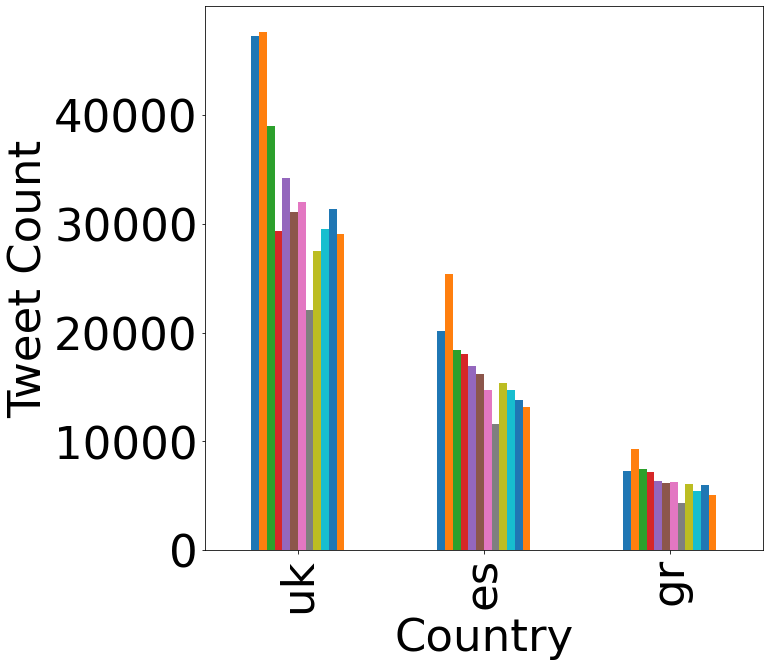

In [20]:
# for uk, es , gr
df.groupby(['mp_country'])['month'].value_counts().unstack().loc[(['uk','es','gr'], [1,2,3,4,5,6,7,8,9,10,11,12])].plot(kind='bar',
                                                                                                                        xlabel='Country',
                                                                                                                        ylabel='Tweet Count',
                                                                                                                        legend=False,
                                                                                                                        figsize=(10,10))

In [25]:
# for all
for country in countries:
    print(country)
    display(df[df['mp_country'] == country]['month'].value_counts().loc[[1,2,3,4,5,6,7,8,9,10,11,12]])

uk


1     47296
2     47606
3     38965
4     29336
5     34215
6     31081
7     31970
8     22044
9     27509
10    29557
11    31330
12    29026
Name: month, dtype: int64

wales


1     5381
2     5462
3     3903
4     3386
5     3874
6     3013
7     3191
8     2393
9     2864
10    2826
11    3410
12    3084
Name: month, dtype: int64

scotland


1     11282
2     13175
3      8988
4      6622
5      7890
6      5600
7      3856
8      5295
9      6285
10     5301
11     6427
12     6241
Name: month, dtype: int64

nireland


1     5945
2     6788
3     5640
4     4579
5     5127
6     6138
7     4798
8     3484
9     4947
10    4505
11    4452
12    5391
Name: month, dtype: int64

es


1     20119
2     25343
3     18407
4     18073
5     16938
6     16167
7     14732
8     11595
9     15376
10    14753
11    13823
12    13175
Name: month, dtype: int64

gr


1     7234
2     9298
3     7421
4     7136
5     6345
6     6140
7     6239
8     4300
9     6060
10    5458
11    5941
12    5083
Name: month, dtype: int64

catalan


1     9512
2     8386
3     6463
4     5537
5     6389
6     6030
7     6047
8     3729
9     5940
10    5856
11    5376
12    5255
Name: month, dtype: int64

basque


1     2103
2     2299
3     1478
4     1287
5     1230
6      989
7      685
8      843
9     1040
10    1118
11    1161
12    1091
Name: month, dtype: int64

In [11]:
for country in countries:
    print(country, len(df[df['mp_country'] == country]))

uk 399935
wales 42787
scotland 86962
nireland 61794
es 198501
gr 76655
catalan 74520
basque 15324


## Percentiles of retweets

In [13]:
df.groupby('mp_country')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
mp_country,,,,,,,,
basque,15324.0,9.885409,36.510585,0.0,0.0,1.0,6.0,1772.0
catalan,74520.0,44.860655,157.066292,0.0,1.0,6.0,25.0,5036.0
es,198501.0,93.245253,374.614715,0.0,1.0,5.0,36.0,25132.0
gr,76655.0,12.442489,39.670344,0.0,0.0,3.0,9.0,3357.0
nireland,61794.0,5.004531,25.064395,0.0,0.0,0.0,3.0,1555.0
scotland,86962.0,21.325154,135.008736,0.0,0.0,1.0,8.0,14205.0
uk,399935.0,43.371380,280.062289,0.0,0.0,2.0,9.0,36689.0
wales,42787.0,4.315353,32.506820,0.0,0.0,0.0,3.0,2519.0


## Correlations

In [20]:
import numpy as np
from scipy.stats import chi2_contingency


table = pd.crosstab(df['retweet_count'], df['multilingual_result'])

chi2, p, dof, expected = chi2_contingency(table)

print(f"chi2 statistic:     {chi2:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

chi2 statistic:     53132
p-value:            0
degrees of freedom: 7544


In [21]:
kruskal(df[df[classifier] == 0][metric], df[df[classifier] == 1][metric], df[df[classifier] == -1][metric]).pvalue

0.0

## Overall Sentiment distribution

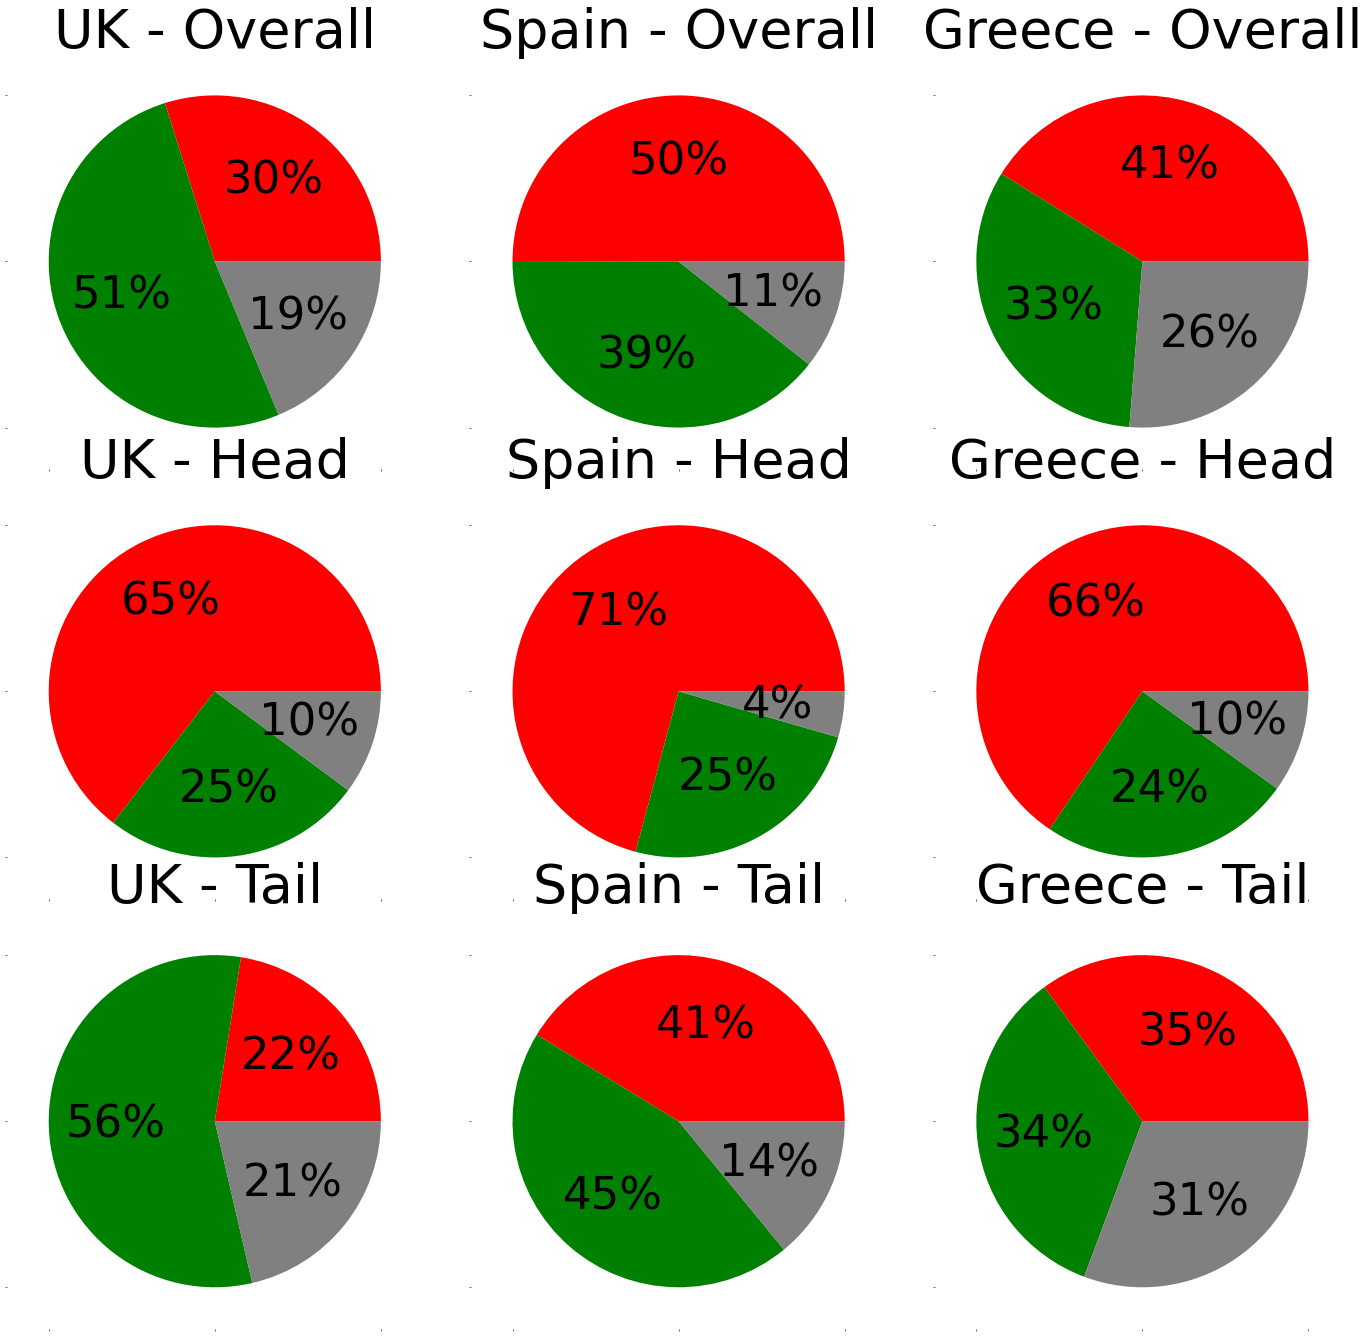

In [14]:
# main parliaments
locations = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
fig, axes = plt.subplots(nrows=3, ncols=3,  sharey=True, sharex=True, figsize=(20, 25))

classifier_result = 'multilingual_result'
figsize = (25,15)
popularity_mode = 'retweet_count'
head_perc=0.95
tail_perc=0.50

def get_plot(country, title, idx_location):
    
    temp = df[(df['mp_country'] == country)]
    (temp[classifier_result].value_counts(normalize=True).loc[[-1,1,0]]*100).plot(kind='pie', 
                                                                            labels=None,
                                                                           colors=['red','green','grey'],
                                                                            autopct='%1.0f%%',
                                                                            ax=axes[locations[idx_location[0]]],
                                                                            title=f'{title} - Overall',
                                                                            ylabel=''
                                                                           )

    head, tail = get_head_tail(temp, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
    (head[classifier_result].value_counts(normalize=True).loc[[-1,1,0]]*100).plot(kind='pie', 
                                                                            labels=None,
                                                                           colors=['red','green','grey'],
                                                                            autopct='%1.0f%%',
                                                                            ax=axes[locations[idx_location[1]]],
                                                                            title=f'{title} - Head',
                                                                            ylabel=''
                                                                           )
    (tail[classifier_result].value_counts(normalize=True).loc[[-1,1,0]]*100).plot(kind='pie', 
                                                                            labels=None,
                                                                           colors=['red','green','grey'],
                                                                            autopct='%1.0f%%',
                                                                            ax=axes[locations[idx_location[2]]],
                                                                            title=f'{title} - Tail',
                                                                            ylabel=''
                                                                            
                                                                           )


for i in range(len(axes)):
    for j in range(3):
        axes[i][j].set_xticklabels([])
    

get_plot('uk', 'UK', [0,3,6])
get_plot('es', 'Spain', [1,4,7])
get_plot('gr', 'Greece', [2,5,8])


fig.tight_layout(h_pad=-8.5)
# fig.savefig('mps_2021_sentiment_distribution_pies.png',dpi=300, bbox_inches='tight', format='png', facecolor ="w")


In [36]:
# all countries
for country in countries:
    temp = df[(df['mp_country'] == country)]
    head, tail = get_head_tail(temp, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
    
    print(country)
    print('Total (-1,0,1)')
    display(temp[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
    print('head')
    display(head[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
    print('tail')
    display(tail[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
    print('\n')

uk
Total (-1,0,1)


[0.3, 0.19, 0.51]

head


[0.65, 0.1, 0.25]

tail


[0.22, 0.21, 0.56]



wales
Total (-1,0,1)


[0.22, 0.17, 0.6]

head


[0.37, 0.14, 0.49]

tail


[0.23, 0.18, 0.6]



scotland
Total (-1,0,1)


[0.31, 0.16, 0.53]

head


[0.6, 0.13, 0.27]

tail


[0.26, 0.17, 0.57]



nireland
Total (-1,0,1)


[0.36, 0.2, 0.44]

head


[0.48, 0.18, 0.34]

tail


[0.39, 0.2, 0.41]



es
Total (-1,0,1)


[0.5, 0.11, 0.39]

head


[0.71, 0.04, 0.25]

tail


[0.41, 0.14, 0.45]



gr
Total (-1,0,1)


[0.41, 0.26, 0.33]

head


[0.66, 0.1, 0.24]

tail


[0.35, 0.31, 0.34]



catalan
Total (-1,0,1)


[0.41, 0.07, 0.52]

head


[0.68, 0.04, 0.28]

tail


[0.34, 0.09, 0.58]



basque
Total (-1,0,1)


[0.56, 0.09, 0.34]

head


[0.75, 0.03, 0.22]

tail


[0.54, 0.1, 0.36]

## Different metrics

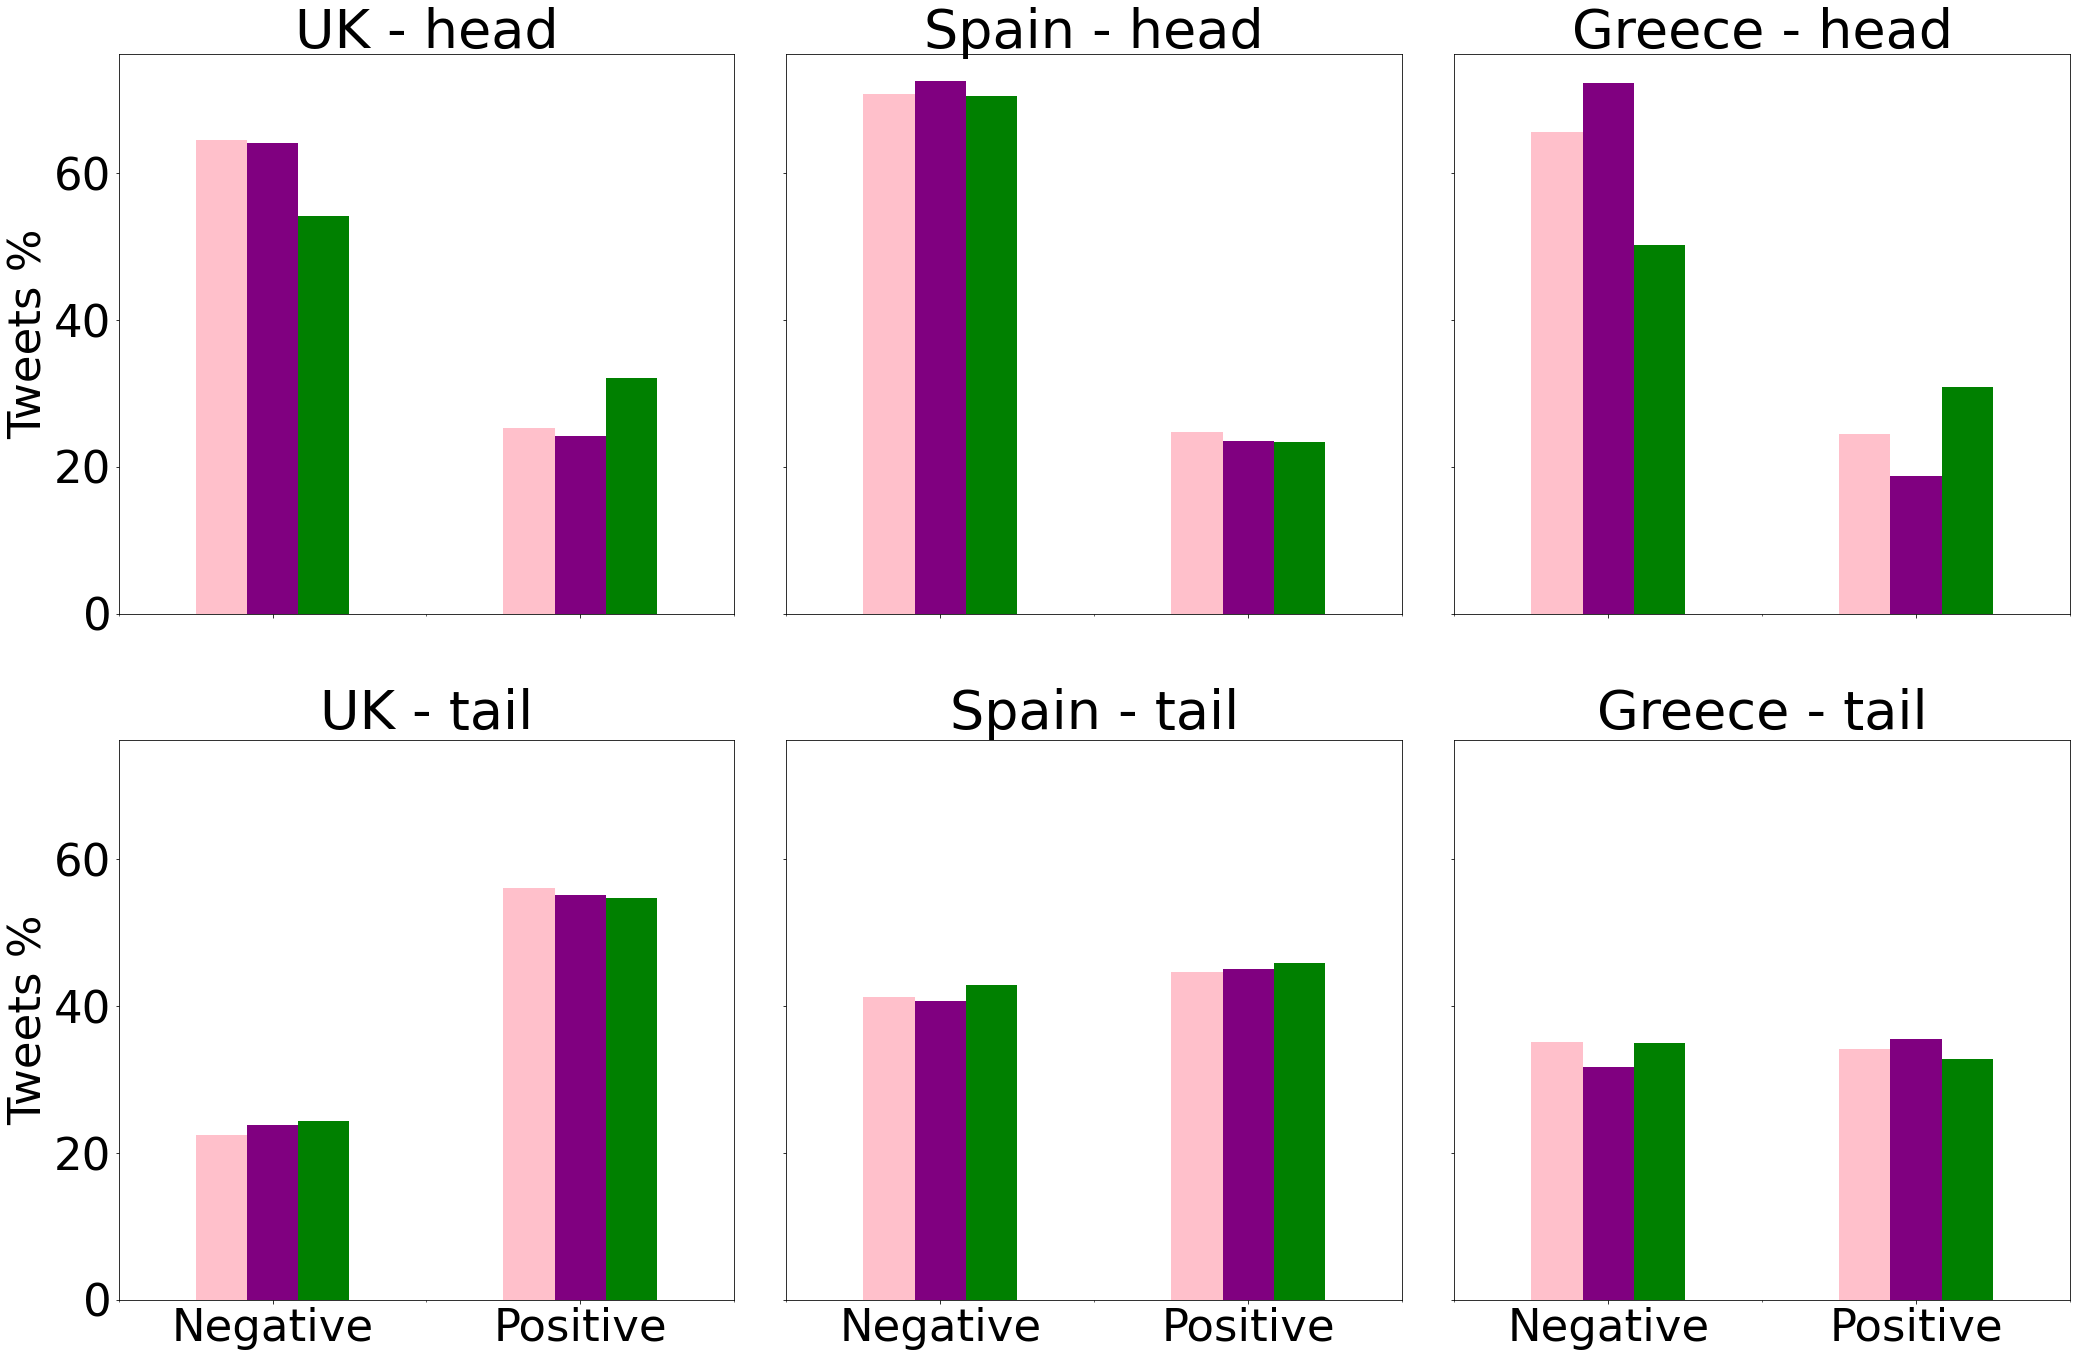

In [39]:
codes_to_countries = {'gr':'Greece', 'es': 'Spain', 'uk': 'UK'}
locations = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
fig, axes = plt.subplots(nrows=2, ncols=3,  sharey=True, sharex=True, figsize=(20, 100))
classifier_result = 'multilingual_result'
figsize = (30,20)
popularity_modes = ['retweet_count', 'retweet_follower_ratio','retweets_in_relation_to_average']
head_perc=0.95
tail_perc=0.50

def metrics_plot(country, axes_location):
    temp = df[(df['mp_country'] == country)]
    head_1, tail_1 = get_head_tail(temp, mode=popularity_modes[0],head_perc=head_perc, tail_perc=tail_perc)
    head_2, tail_2 = get_head_tail(temp, mode=popularity_modes[1],head_perc=head_perc, tail_perc=tail_perc)
    head_3, tail_3 = get_head_tail(temp, mode=popularity_modes[2],head_perc=head_perc, tail_perc=tail_perc)

    # for head
    group1 = (pd.DataFrame(head_1[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'retweets/followers'})
    group2 = (pd.DataFrame(head_2[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'retweets/average retweets'})
    group3 = (pd.DataFrame(head_3[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'retweet_count'})
    groups_all = pd.concat([group1,group2,group3],axis=1)
    groups_all.loc[[-1,1]].plot(figsize=figsize, kind='bar',title=f"{codes_to_countries[country]} - head", color=['pink', 'purple', 'green'], ylabel='Tweets %', legend=False, width=0.5, ax=axes[axes_location[0]])
    
    # for tail
    group1 = (pd.DataFrame(tail_1[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'retweets/followers'})
    group2 = (pd.DataFrame(tail_2[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'retweets/average retweets'})
    group3 = (pd.DataFrame(tail_3[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'retweet_count'})
    groups_all = pd.concat([group1,group2,group3],axis=1)
    groups_all.loc[[-1,1]].plot(figsize=figsize, kind='bar',title=f"{codes_to_countries[country]} - tail", color=['pink', 'purple', 'green'], ylabel='Tweets %',legend=False, width=0.5, ax=axes[axes_location[1]])


    
metrics_plot('uk', (locations[0], locations[3]))
metrics_plot('es', (locations[1], locations[4]))
metrics_plot('gr', (locations[2], locations[5]))

for i in range(len(axes)):
    for j in range(3):
        axes[i][j].set_xticklabels(['Negative', 'Positive'],rotation = 0)


#axes[0][0].legend(fontsize=28,loc=1)
# get common labels
#grey_patch = mpatches.Patch(color='grey', label='0: Neutral')
red_patch = mpatches.Patch(color='pink', label='-1: retweets/followers')
green_patch = mpatches.Patch(color='purple', label='1: retweets/average retweets')
#fig.legend(handles=[red_patch, green_patch],fancybox=True,loc=2,fontsize=33)
#fig.suptitle(f'Overall sentiment distribution', fontsize=40)
fig.tight_layout()
#fig.savefig('mps_2021_sentiment_distribution_other_metrics.png',dpi=300, bbox_inches='tight', format='png', facecolor ="w")



## Parties Comparison

In [59]:
def get_party_sentiment(df,country,axes,position):
    # party sentiment analysis
    to_plot =  df.groupby('mp_party')['sentiment_prediction'].value_counts(normalize=True).unstack()
    
    # copy parties to consider and check if any are missing in index
    parties = [ x for x in PARTIES_TO_CONSIDER[country]]
    for i in PARTIES_TO_CONSIDER[country]:
        if i not in to_plot.index:
            parties.remove(i)
    
    df.groupby('mp_party')['sentiment_prediction'].value_counts(normalize=True).unstack().loc[parties]\
                                                                              .plot(figsize=(50,40), kind='bar',  color=['red', 'grey', 'blue'],
                                                                                    title=f"{country}",
                                                                                    ax=axes[position],
                                                                                    #xlabel='Sentiment',
                                                                                    legend=False
                                                                                   )


In [60]:
party_order = {"uk":['Conservatives', 'Labour', 'SNP', 'LibDem', 'DUP'], 
               'scotland':['SNP', 'Conservatives', 'Labour', 'Green', 'LibDem'],
              'es':['PSOE', 'PP', 'VOX', 'UP', 'ERC-Sob'],
              'gr':['New Democracy', 'Syriza', 'MfC', 'Greek Solution', 'MeRA25']}
colors = {"uk":['#0087dc', '#e4003b', '#fdf38e', '#faa61a', '#d46a4c'],
          'scotland':['#fdf38e', '#0087dc', '#e4003b', '#00b140', '#faa61a'],
         'es':['#ef1c27', '#1d84ce', '#63be21', '#5a205a', '#ffb232'],
         'gr':['#1b5cc7', '#ee808f', '#179045', '#5493ce', '#f85925']}
titles = {'uk': 'UK', 'gr':'Greece', 'es':'Spain'}



/tmp/ipykernel_445320/1425642877.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['order'] = temp['mp_party'].apply(lambda x: party_order[country].index(x))


mp_party,Conservatives,Labour,SNP,LibDem,DUP
multilingual_result,,,,,
-1.0,16.515898,35.963696,38.506805,40.768967,29.235880
0.0,21.107582,18.127337,16.050841,16.329851,19.186047
1.0,62.376520,45.908967,45.442354,42.901182,51.578073


/tmp/ipykernel_445320/1425642877.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['order'] = temp['mp_party'].apply(lambda x: party_order[country].index(x))


mp_party,PSOE,PP,VOX,UP,ERC-Sob
multilingual_result,,,,,
-1.0,38.154040,58.316014,60.118341,53.846533,51.857641
0.0,17.844734,7.895017,7.664068,6.254925,12.720933
1.0,44.001226,33.788969,32.217591,39.898542,35.421426


/tmp/ipykernel_445320/1425642877.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['order'] = temp['mp_party'].apply(lambda x: party_order[country].index(x))


mp_party,New Democracy,Syriza,MfC,Greek Solution,MeRA25
multilingual_result,,,,,
-1.0,19.610098,59.280480,42.048670,79.057727,48.530806
0.0,33.090870,22.610325,26.070553,7.153335,33.957346
1.0,47.299032,18.109195,31.880777,13.788938,17.511848


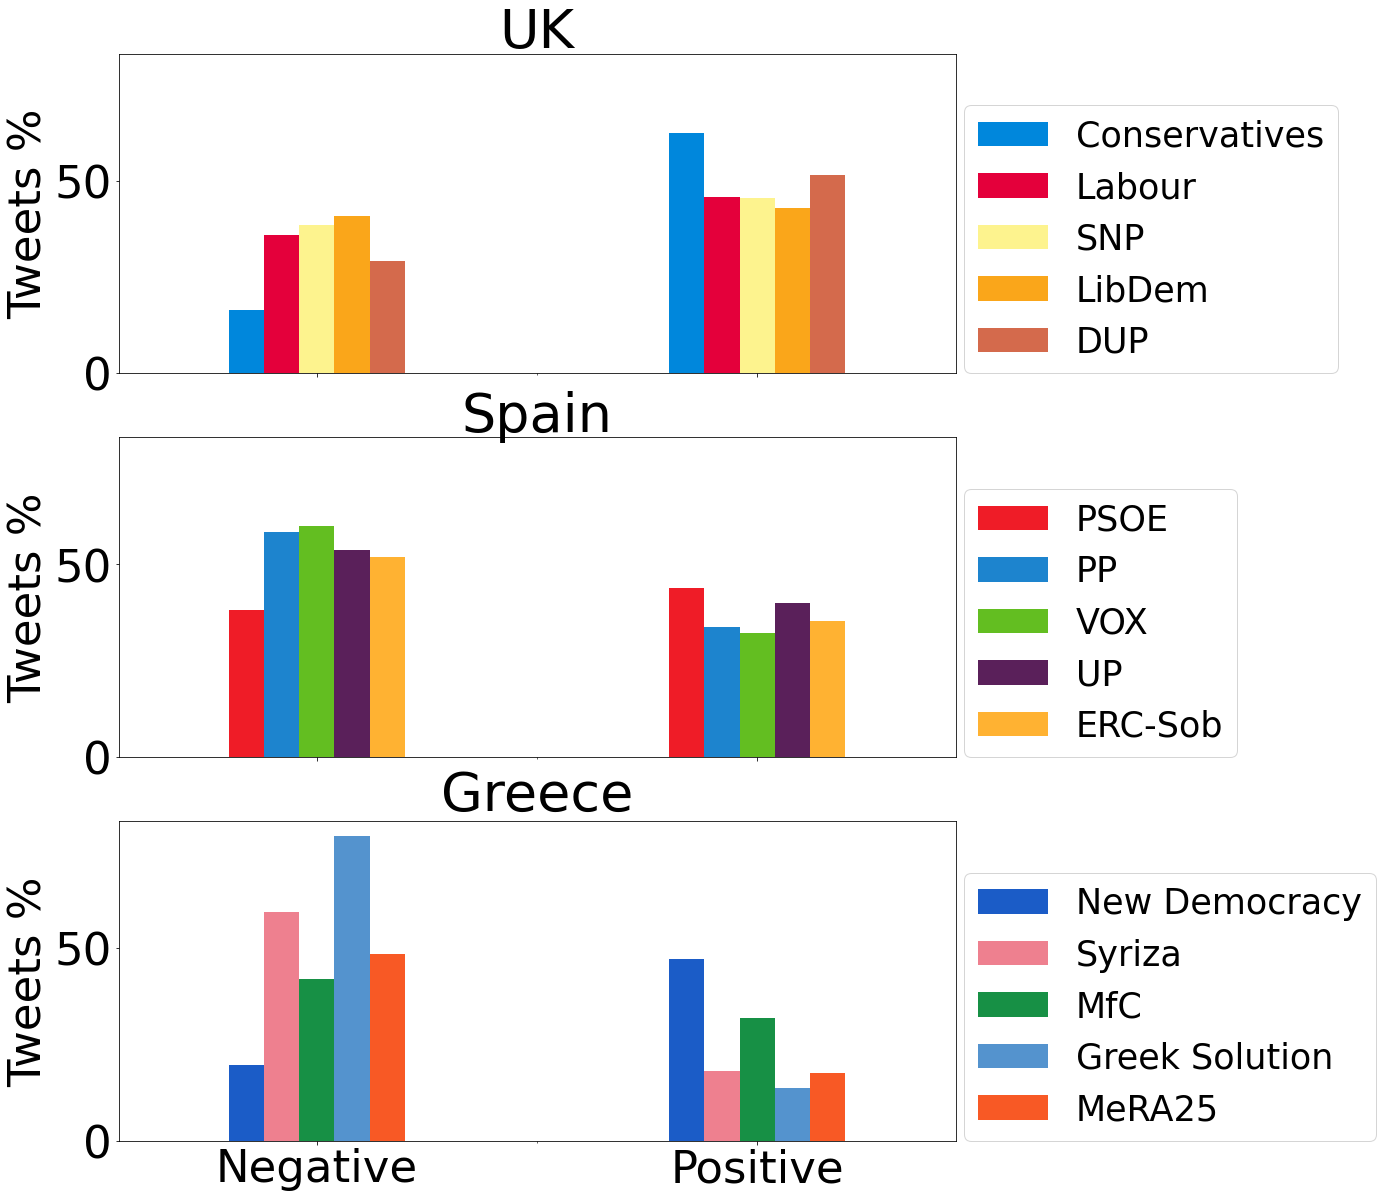

In [61]:
locations = [0,1,2]
fig, axes = plt.subplots(nrows=3, ncols=1,  sharey=True, figsize=(15, 40), sharex=True)
classifier_result = 'multilingual_result'
figsize = (15,20)
classifier_result = 'multilingual_result'

def plot_parties(country, idx_loc, classifier = 'multilingual_result'):
    temp = df[(df['mp_country'] == country) & (df['mp_party'].isin(party_order[country]))]# & (df[classifier].isin([-1,1]))]

    #temp['mp_party'] = temp['mp_party'].replace({'Conservative':'Conservatives', 'Liberal Democrat': 'LibDem'})
    temp['order'] = temp['mp_party'].apply(lambda x: party_order[country].index(x))
    temp = temp.sort_values(by='order')

    test = temp.groupby(classifier)['mp_party'].value_counts()
    for idx in test.index:
        party_count = len(temp[temp['mp_party'] == idx[1]])
        test.loc[idx] = (test.loc[idx]/party_count) * 100
    
    display(test.unstack()[party_order[country]])
    ax = test.unstack()[party_order[country]].loc[[-1,1]].plot(figsize=figsize, kind='bar', color=colors[country],
                                                   title=titles[country], xlabel='', legend=True, ylabel='Tweets %', ax=axes[locations[idx_loc]], width=0.4)
    ax.set_xticklabels(['Negative', 'Positive'],rotation=0)



plot_parties('uk', 0)
plot_parties('es', 1)
plot_parties('gr', 2)


axes[0].legend(loc=(1.01,-0.0),fontsize=35)
axes[1].legend(loc=(1.01,-0.0),fontsize=35)
axes[2].legend(loc=(1.01,-0.0),fontsize=35)

#fig.tight_layout()
fig.savefig('mps_2021_parties.png',dpi=300, bbox_inches='tight', format='png', facecolor ="w")


# uk 2021 vs uk 2016, 2014

In [11]:
uk = df[df['mp_country'] == 'uk']

uk_2016 = pd.read_pickle('./data/control/uk_2016.pkl')

# create month column
uk_2016['created_at'] = pd.to_datetime(uk_2016['created_at'],utc=True)
uk_2016['month'] = uk_2016['created_at'].dt.strftime('%m')
uk_2016['month'] = uk_2016['month'].astype(int)

# ignore entries with no tokens (most of them only @handles or urls)
before = len(uk_2016)
uk_2016 = uk_2016[uk_2016.tokens.str.len() > 0]
uk_2016 = uk_2016.reset_index()
after = len(uk_2016)
print(f"Ignoring {before - after} tweets with no content (handles/urls)\n")

# ignore doublications 
uk_2016 = uk_2016.drop_duplicates(subset='id')
print(f"Ignoring {after - len(uk_2016)} duplicate tweets \n")

uk_2014 = pd.read_pickle('./data/control/uk_2014.pkl')
# create month column
uk_2014['created_at'] = pd.to_datetime(uk_2014['created_at'],utc=True)
uk_2014['month'] = uk_2014['created_at'].dt.strftime('%m')
uk_2014['month'] = uk_2014['month'].astype(int)

# ignore entries with no tokens (most of them only @handles or urls)
before = len(uk_2014)
uk_2014 = uk_2014[uk_2014.tokens.str.len() > 0]
uk_2014 = uk_2014.reset_index()
after = len(uk_2014)
print(f"Ignoring {before - after} tweets with no content (handles/urls)\n")

# ignore doublications 
uk_2014 = uk_2014.drop_duplicates(subset='id')
print(f"Ignoring {after - len(uk_2014)} duplicate tweets \n")


2022-01-10:17:43:44,399 INFO     [lexical_analysis.py:229] Using en_core_web_sm
Tokenizing text: 100%|█████████████████████| 439143/439143 [04:27<00:00, 1644.34it/s]


Ignoring 8809 tweets with no content (handles/urls)

Ignoring 796 duplicate tweets 



2022-01-10:17:48:20,439 INFO     [lexical_analysis.py:229] Using en_core_web_sm
Tokenizing text: 100%|█████████████████████| 215202/215202 [02:20<00:00, 1526.91it/s]


Ignoring 3275 tweets with no content (handles/urls)

Ignoring 8973 duplicate tweets 



In [14]:
classifier_result = 'multilingual_result'
popularity_mode = 'retweet_count'#'retweets_in_relation_to_average'#
head_perc=0.95
tail_perc=0.50

uk = df[df['mp_country'] == 'uk']
uk['year'] = 2021

h,t  =  get_head_tail(uk, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
uk['head_tail'] = 'none'
uk.loc[h.index, 'head_tail'] = 'head'
uk.loc[t.index, 'head_tail'] = 'tail'

uk_2014['year'] = 2014
h,t  =  get_head_tail(uk_2014, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
uk_2014['head_tail'] = 'none'
uk_2014.loc[h.index, 'head_tail'] = 'head'
uk_2014.loc[t.index, 'head_tail'] = 'tail'

uk_2016['year'] = 2016
h,t  =  get_head_tail(uk_2016, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
uk_2016['head_tail'] = 'none'
uk_2016.loc[h.index, 'head_tail'] = 'head'
uk_2016.loc[t.index, 'head_tail'] = 'tail'



uk_all = pd.concat([uk_2014, uk_2016, uk])



/tmp/ipykernel_445320/3178575297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk['year'] = 2021
/tmp/ipykernel_445320/3178575297.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk['head_tail'] = 'none'
/home/dimosthenis/.local/share/virtualenvs/scraping-TqoyyuT9/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

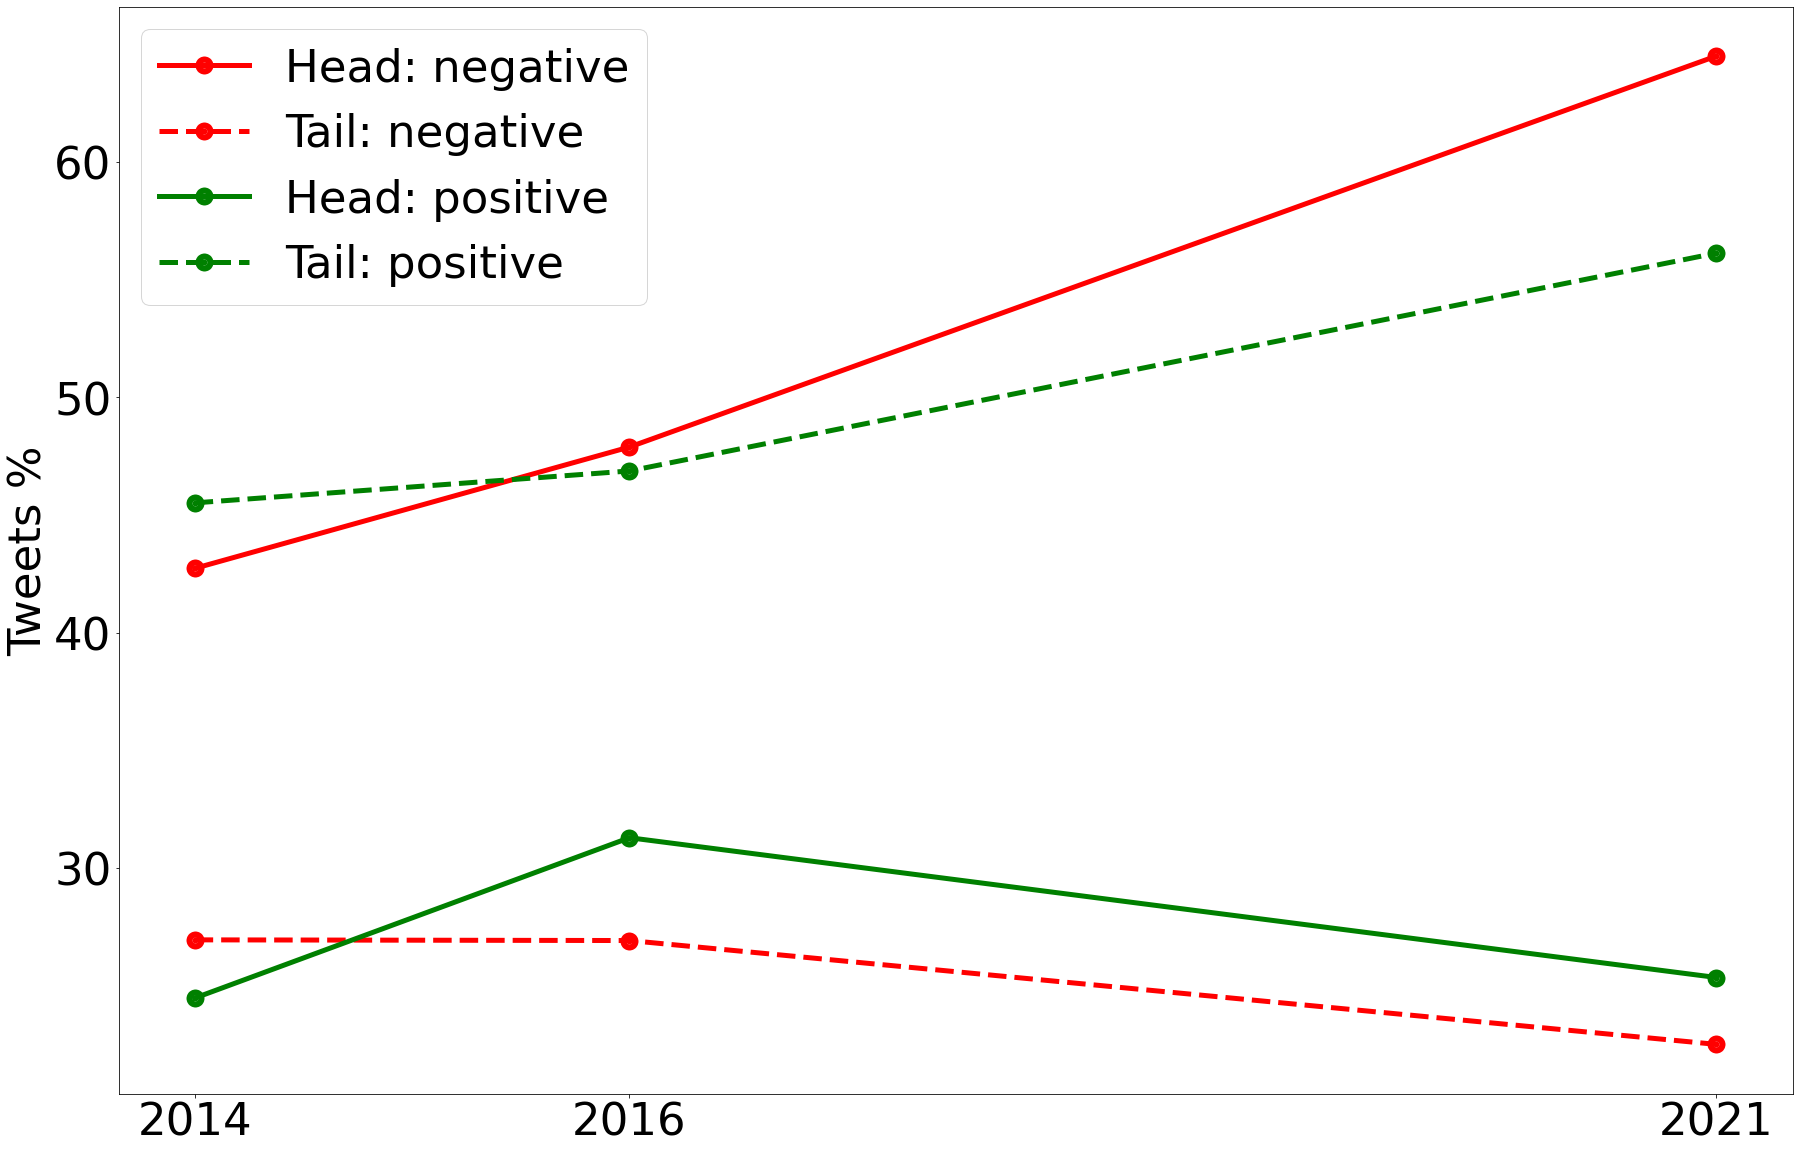

In [17]:
to_plot = (uk_all.groupby(['year','head_tail'])['multilingual_result'].value_counts(normalize=True)*100).unstack().unstack()
to_plot = to_plot[[(-1, 'head'),
                 (-1, 'tail'),        
                 ( 1, 'head'),
                 ( 1, 'tail')]]

to_plot.plot(legend=True,
             color=['red','red','green','green'],
             linewidth=5,
             style=['-','--','-','--'],
             marker='o',
             markeredgewidth=12,
            figsize=(30,20),
            ylabel='Tweets %',
            xlabel='')
plt.xticks([2014, 2016, 2021])
plt.legend(title='',labels=['Head: negative', 'Tail: negative', 'Head: positive','Tail: positive'])
plt.savefig('uk_comparison_lineplot.png',dpi=300, bbox_inches='tight', format='png', facecolor ="w")

In [7]:
# overall uk_2014 & uk_2016 sentiment distributions 
popularity_mode = 'retweet_count'
classifier_result = 'multilingual_result'
head_perc=0.95
tail_perc=0.50

head, tail = get_head_tail(uk_2014, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
print('UK 2014')
print('Total (-1,0,1)')
display(uk_2014[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
print('head')
display(head[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
print('tail')
display(tail[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
print('\n')


head, tail = get_head_tail(uk_2016, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
print('UK 2016')
print('Total (-1,0,1)')
display(uk_2016[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
print('head')
display(head[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
print('tail')
display(tail[classifier_result].value_counts(normalize=True).loc[[-1,0,1]].round(2).tolist())
print('\n')

UK 2014
Total (-1,0,1)


[0.29, 0.3, 0.41]

head


[0.43, 0.33, 0.24]

tail


[0.27, 0.28, 0.46]



UK 2016
Total (-1,0,1)


[0.29, 0.25, 0.46]

head


[0.48, 0.21, 0.31]

tail


[0.27, 0.26, 0.47]

# Bertweet-Sent  vs XLM-T-Sent

In [13]:
uk = df[df['mp_country'] == 'uk']

Overall agreement

In [14]:
len(uk[uk.multilingual_result == uk.sentiment_bbs])/len(uk)

0.7996499431157563

In [15]:
cohen_kappa_score(uk.multilingual_result , uk.sentiment_bbs)

0.6816828411618474

Head vs Tail comparison

In [20]:
classifier_result = 'multilingual_result'
popularity_mode = 'retweet_count'
head_perc=0.95
tail_perc=0.50

uk = df[df['mp_country'] == 'uk']

# XLM-T-Sent results
h,t  =  get_head_tail(uk, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)

h['multilingual_result'].value_counts(normalize=True).round(2),t['multilingual_result'].value_counts(normalize=True).round(2)

/tmp/ipykernel_501418/83855770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk['year'] = 2021


(-1.0    0.65
  1.0    0.25
  0.0    0.10
 Name: multilingual_result, dtype: float64,
  1.0    0.56
 -1.0    0.22
  0.0    0.21
 Name: multilingual_result, dtype: float64)

In [21]:
# BertweetSent results
h,t  =  get_head_tail(uk, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)

h['sentiment_bbs'].value_counts(normalize=True).round(2),t['sentiment_bbs'].value_counts(normalize=True).round(2)

/tmp/ipykernel_501418/680038202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk['year'] = 2021


(-1.0    0.62
  1.0    0.20
  0.0    0.19
 Name: sentiment_bbs, dtype: float64,
  1.0    0.52
  0.0    0.30
 -1.0    0.18
 Name: sentiment_bbs, dtype: float64)

# MPs VS General population

In [34]:
uk_verified = pd.read_pickle('./data/control/verified_uk.pkl')
uk_random = pd.read_pickle('./data/control/random_uk.pkl')
uk = df[df['mp_country'] == 'uk']


es_verified = pd.read_pickle('./data/control/verified_es.pkl')
es_random = pd.read_pickle('./data/control/random_es.pkl')
es = df[df['mp_country'] == 'es']


gr_verified = pd.read_pickle('./data/control/random_gr.pkl')
gr_random = pd.read_pickle('./data/control/verified_gr.pkl')
gr = df[df['mp_country'] == 'gr']

['uk']


,Random users,Random users > 1k,Verified users,MPs
-1.0,27.31,25.96,34.43,64.52
0.0,19.03,19.29,27.64,10.15
1.0,53.66,54.75,37.92,25.32


,Random users,Random users > 1k,Verified users,MPs
-1.0,30.57,28.98,21.18,22.48
0.0,18.92,18.10,34.22,21.38
1.0,50.51,52.93,44.60,56.14


['es']


,Random users,Random users > 1k,Verified users,MPs
-1.0,42.86,40.92,44.64,70.83
0.0,13.94,13.41,21.81,4.47
1.0,43.20,45.67,33.56,24.70


,Random users,Random users > 1k,Verified users,MPs
-1.0,46.17,43.09,30.62,41.29
0.0,15.95,15.87,31.51,14.07
1.0,37.89,41.04,37.87,44.64


['gr']


,Random users,Random users > 1k,Verified users,MPs
-1.0,27.52,27.51,38.18,65.58
0.0,32.31,32.32,16.87,9.95
1.0,40.17,40.17,44.95,24.47


,Random users,Random users > 1k,Verified users,MPs
-1.0,25.69,25.72,39.08,35.06
0.0,49.65,49.67,19.90,30.71
1.0,24.66,24.61,41.02,34.23


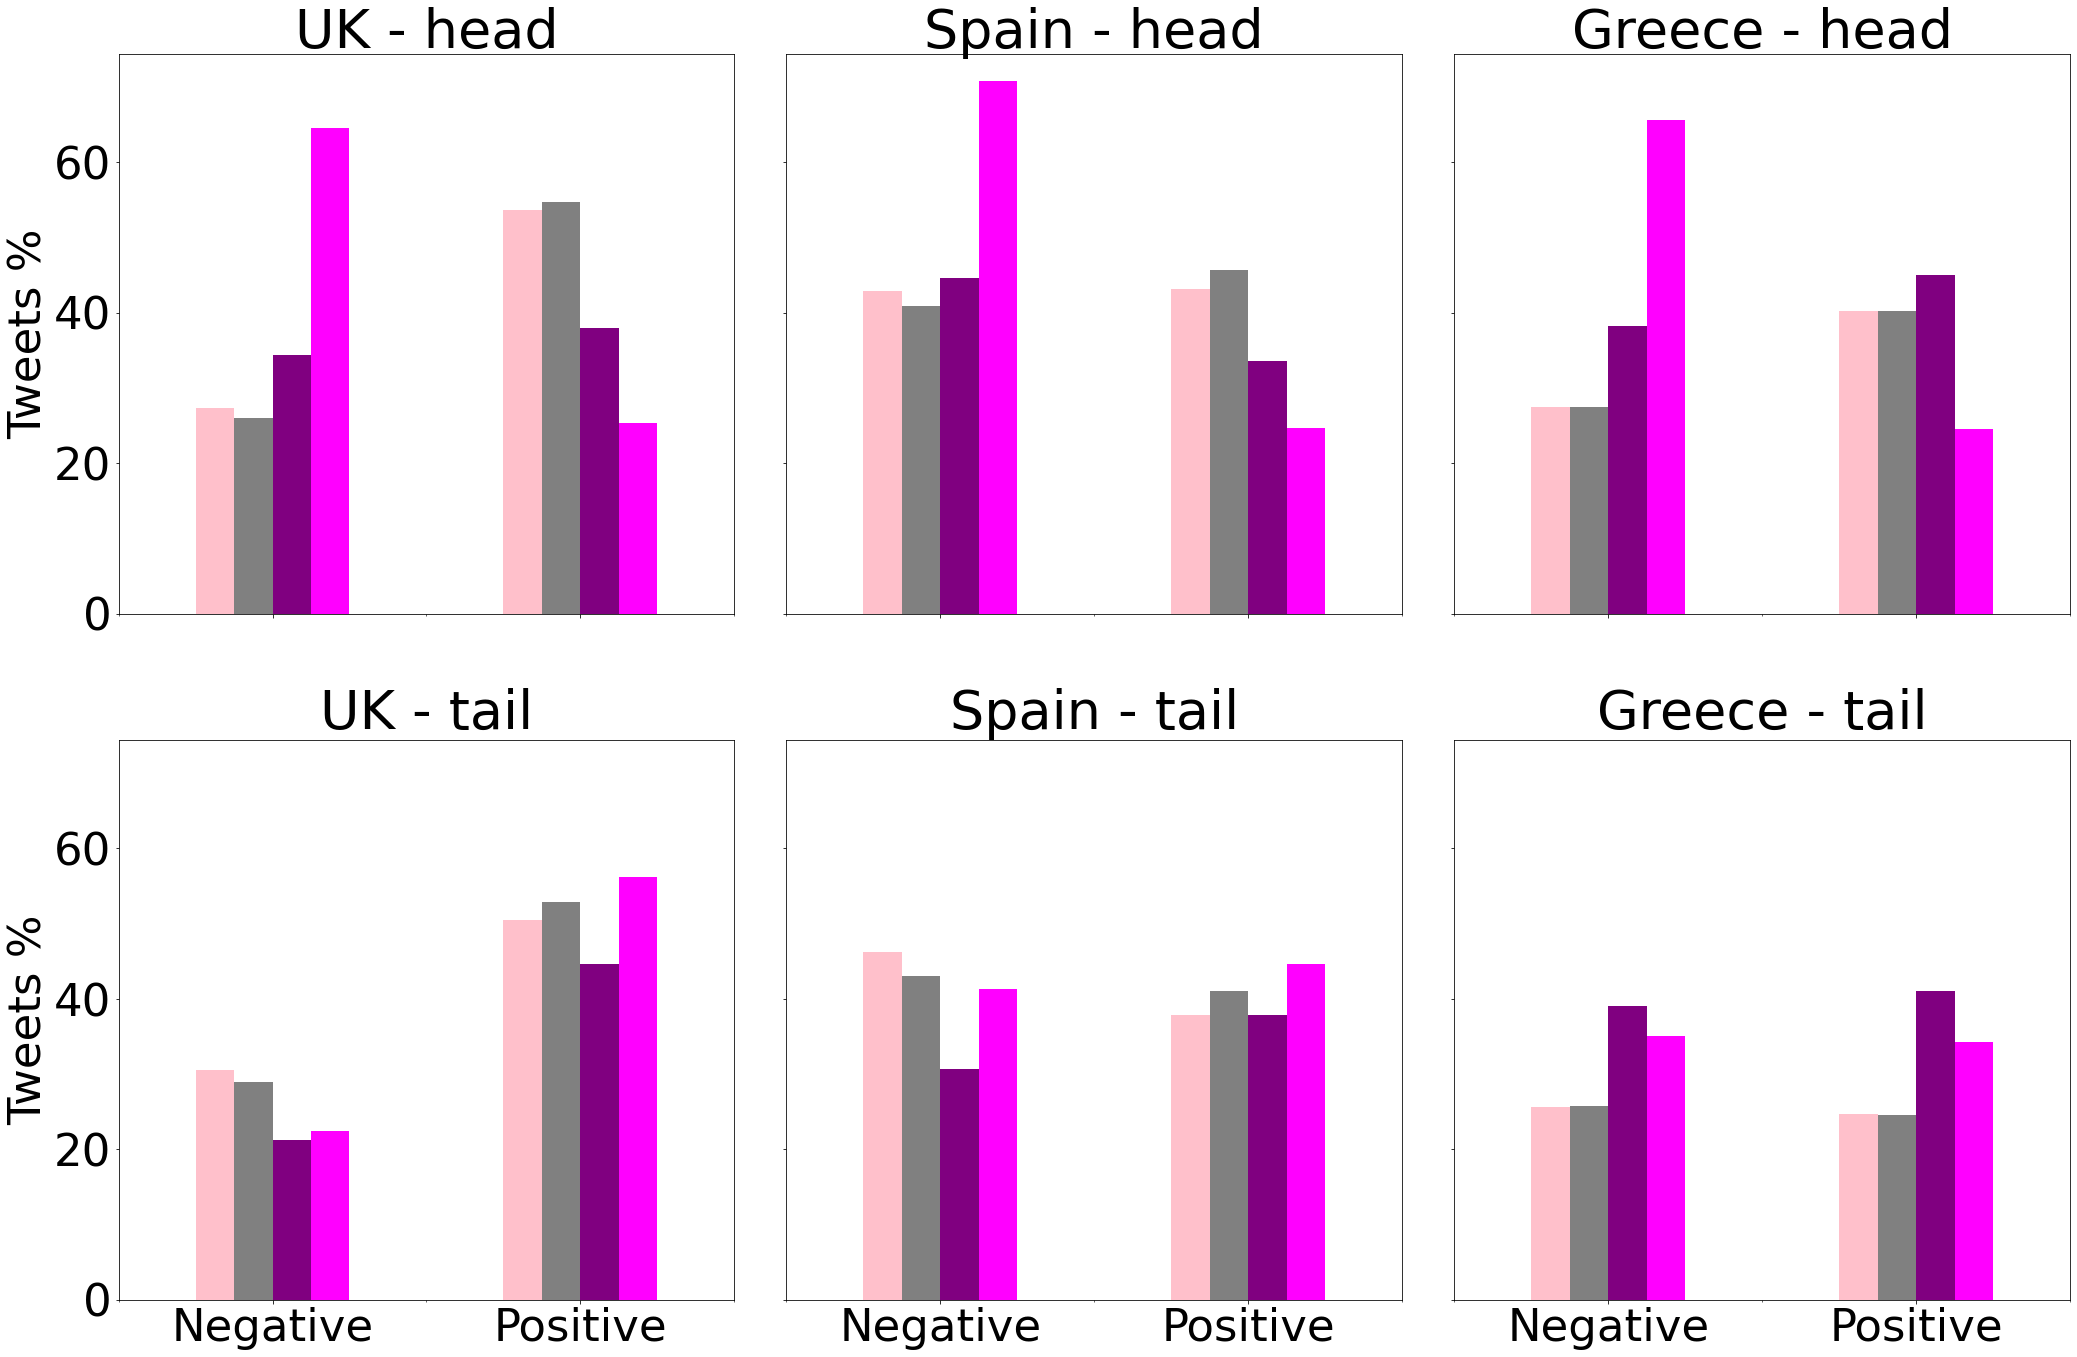

In [36]:
locations = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
fig, axes = plt.subplots(nrows=2, ncols=3,  sharey=True, sharex=True, figsize=(20, 100))

def make_plots(df_mp, df_random, df_verified, position, title=''):
    #country = 'uk'
    print(df_mp.mp_country.unique())
    classifier_result = 'multilingual_result'
    popularity_mode = 'retweet_count'#'retweets_in_relation_to_average'#
    head_perc=0.95
    tail_perc=0.50
    figsize = (30,20)

    
    head_mp, tail_mp = get_head_tail(df_mp, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
    head_random, tail_random = get_head_tail(df_random, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
    head_random_popular, tail_random_popular = get_head_tail(df_random[df_random.followers_count>=1000], mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
    head_verified, tail_verified = get_head_tail(df_verified, mode=popularity_mode,head_perc=head_perc, tail_perc=tail_perc)
    
    # head
    plot_random = (pd.DataFrame(head_random[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'Random users'})
    plot_random_popular = (pd.DataFrame(head_random_popular[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'Random users > 1k'})
    plot_verified = (pd.DataFrame(head_verified[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'Verified users'})
    plot_mp = (pd.DataFrame(head_mp[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'MPs'})
    
    
    plot_all = pd.concat([plot_random,plot_random_popular,plot_verified,plot_mp],axis=1)
    display(round(plot_all,2))
    plot_all.loc[[-1,1]].plot(figsize=figsize, kind='bar',title=f"{title} - head", color = ['pink', 'grey', 'purple', 'fuchsia'],
                              ylabel='Tweets %', legend=False, width=0.5, ax=axes[position[0]])
    
    
    #tail
    plot_random = (pd.DataFrame(tail_random[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'Random users'})
    plot_random_popular = (pd.DataFrame(tail_random_popular[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'Random users > 1k'})
    plot_verified = (pd.DataFrame(tail_verified[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'Verified users'})
    plot_mp = (pd.DataFrame(tail_mp[classifier_result].value_counts(normalize=True))*100).rename(columns={'multilingual_result':'MPs'})
    
    
    plot_all = pd.concat([plot_random,plot_random_popular,plot_verified,plot_mp],axis=1)
    display(round(plot_all,2))
    plot_all.loc[[-1,1]].plot(figsize=figsize, kind='bar',title=f"{title} - tail", color = ['pink', 'grey', 'purple', 'fuchsia'],
                              ylabel='Tweets %', legend=False, width=0.5, ax=axes[position[1]])
    

    
    
       
make_plots(uk, uk_random, uk_verified, [(0,0),(1,0)], 'UK')
make_plots(es, es_random, es_verified,[(0,1),(1,1)], 'Spain')
make_plots(gr, gr_random, gr_verified,[(0,2),(1,2)], 'Greece')

for i in range(len(axes)):
    for j in range(3):
        axes[i][j].set_xticklabels(['Negative', 'Positive'],rotation = 0)

fig.tight_layout()
#fig.savefig('mps_vs_general.png',dpi=300, bbox_inches='tight', format='png', facecolor ="w")